In [9]:
import pandas as pd
import os
import glob
import io 
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import seaborn as sns
from scipy.stats import zscore
from brainspace.utils.parcellation import reduce_by_labels, map_to_mask
from brainspace.gradient import GradientMaps
from brainspace.datasets import load_parcellation
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels
from sklearn.metrics.pairwise import cosine_similarity
import dill

emb_dir ='/home/dimuthu1/scratch/PPMI_project2/derivatives/analysis/gradients/bs_emb'

emb_ctx_12 = dill.load(open(emb_dir+"/emb_ctx_12.pickle", "rb"))
emb_ctx_24 = dill.load(open(emb_dir+"/emb_ctx_24.pickle", "rb"))

emb_sbctx_L_12 = dill.load(open(emb_dir+"/emb_sbctx_L_12.pickle", "rb"))
emb_sbctx_L_24 = dill.load(open(emb_dir+"/emb_sbctx_L_24.pickle", "rb"))

emb_sbctx_R_12 = dill.load(open(emb_dir+"/emb_sbctx_R_12.pickle", "rb"))
emb_sbctx_R_24 = dill.load(open(emb_dir+"/emb_sbctx_R_24.pickle", "rb"))
#emb = np.load(emb_dir+"/emb_ctx_12.pickle")

In [10]:
labels_gii = nib.load('../cfg/Schaefer2018_1000Parcels_7Networks_order.dlabel.nii').get_fdata()

print(labels_gii[0])
mask = ~np.isin(labels_gii[0],0)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
[479. 170. 124. ... 938. 938. 862.]


In [11]:
 def project_to_cortex(emb_ctx,session):
    grad = [None] * 4
    for i, g in enumerate(emb_ctx.gradients_.T):
        grad[i] = map_to_labels(g, labels_gii[0], mask=mask, fill=np.nan)

    gii = nib.gifti.GiftiImage()

    for g in range(0,len(grad)):
        gii.add_gifti_data_array(
            nib.gifti.GiftiDataArray(data=grad[g][:32492].astype(np.float32)) # For left hemisphere, right hemisphere change to [32492:]
        )
    nib.save(gii, emb_dir+'/mean_ctx_L_gradients_'+session+'.func.gii')

    for i, g in enumerate(emb_ctx.gradients_.T):
        grad[i] = map_to_labels(g, labels_gii[0], mask=mask, fill=np.nan)

    gii = nib.gifti.GiftiImage()

    for g in range(0,len(grad)):
        gii.add_gifti_data_array(
            nib.gifti.GiftiDataArray(data=grad[g][32492:].astype(np.float32)) # For left hemisphere, right hemisphere change to [32492:]
        )
    nib.save(gii, emb_dir+'/mean_ctx_R_gradients_'+session+'.func.gii')

In [12]:
project_to_cortex(emb_ctx_12,'month12')
project_to_cortex(emb_ctx_24,'month24')

In [13]:
def get_grad_df(emb,region):
  
    grad_1 = emb.gradients_.T[0]
    grad_2 = emb.gradients_.T[1]
    grad_3 = emb.gradients_.T[2]
    #grad_4 = gm.gradients_.T[3]

    gradient_df = pd.DataFrame({region+'_grad_1': grad_1, region+'_grad_2': grad_2, region+'_grad_3': grad_3})

    return gradient_df

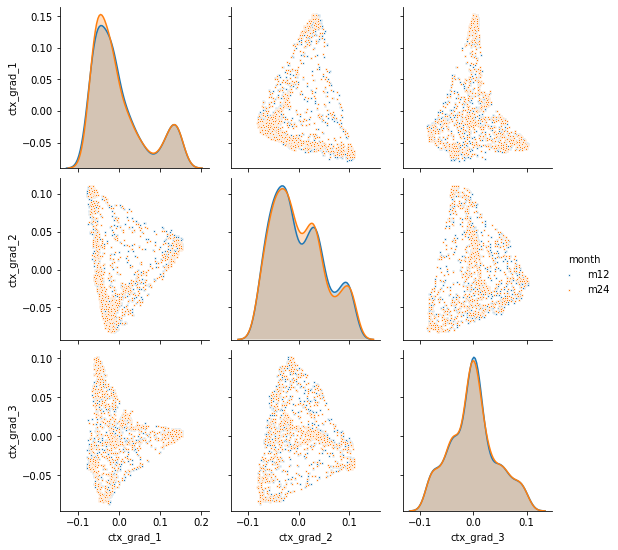

In [14]:
df_ctx_12 = get_grad_df(emb_ctx_12,'ctx')
df_ctx_24 = get_grad_df(emb_ctx_24,'ctx')


df_ctx_12['month'] = 'm12'
df_ctx_24['month'] = 'm24'


df_ctx_all = df_ctx_12.append(df_ctx_24)

out_path='/home/dimuthu1/scratch/PPMI_project2/derivatives/analysis/plots/group'
sns_plot = sns.pairplot(df_ctx_all,plot_kws={"s": 5}, hue="month")
sns_plot.savefig(out_path+"/mean_ctx_plot.png")

      sbctx_grad_1  sbctx_grad_2  sbctx_grad_3
0         0.016556      0.031366      0.022844
1         0.004710      0.013974      0.043338
2         0.012772      0.026546      0.034220
3         0.004121      0.050533     -0.011156
4         0.003886      0.021119      0.008442
...            ...           ...           ...
1909      0.012031      0.031920      0.050279
1910      0.012508      0.029778      0.036763
1911      0.012793      0.045215      0.017584
1912      0.013427      0.019005      0.032953
1913      0.013804      0.038569      0.029435

[1914 rows x 3 columns]


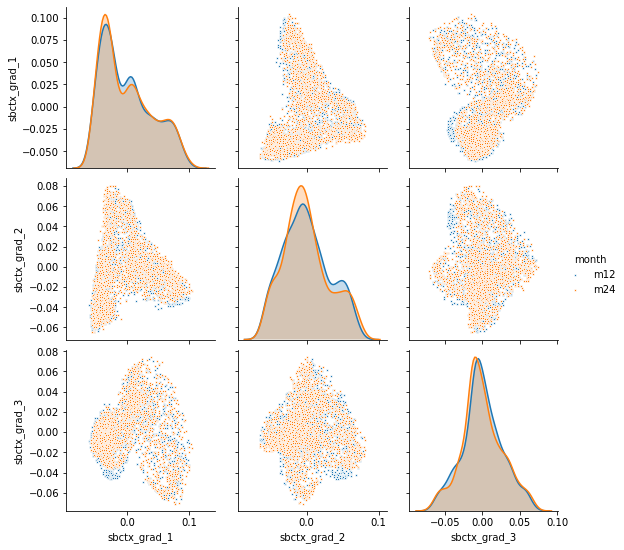

In [15]:
df_sbctx_L_12 = get_grad_df(emb_sbctx_L_12,'sbctx')
df_sbctx_L_24 = get_grad_df(emb_sbctx_L_24,'sbctx')

print(df_sbctx_L_12)

df_sbctx_L_12['month'] = 'm12'
df_sbctx_L_24['month'] = 'm24'


df_sbctx_L_all = df_sbctx_L_12.append(df_sbctx_L_24)

out_path='/home/dimuthu1/scratch/PPMI_project2/derivatives/analysis/plots/group'
sns_plot = sns.pairplot(df_sbctx_L_all,plot_kws={"s": 5}, hue="month")
sns_plot.savefig(out_path+"/mean_sbctx_L_plot.png")

      sbctx_grad_1  sbctx_grad_2  sbctx_grad_3
0        -0.007216      0.058735      0.030080
1        -0.005568      0.032597      0.007049
2        -0.011433      0.058545      0.015575
3        -0.000776      0.020296      0.001914
4        -0.015392      0.038999     -0.001922
...            ...           ...           ...
1909      0.013471      0.025407      0.015853
1910      0.009533      0.046488      0.010829
1911      0.018199      0.037989     -0.006552
1912      0.006683      0.037929      0.008551
1913      0.016167      0.034147     -0.011431

[1914 rows x 3 columns]


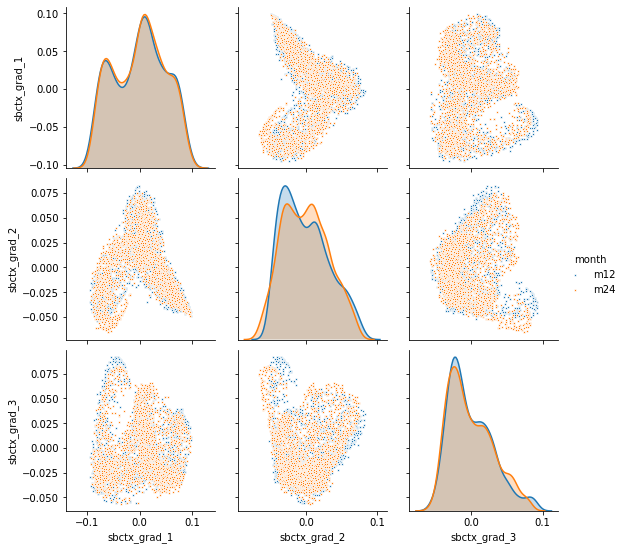

In [16]:
df_sbctx_R_12 = get_grad_df(emb_sbctx_R_12,'sbctx')
df_sbctx_R_24 = get_grad_df(emb_sbctx_R_24,'sbctx')

print(df_sbctx_R_12)

df_sbctx_R_12['month'] = 'm12'
df_sbctx_R_24['month'] = 'm24'


df_sbctx_R_all = df_sbctx_R_12.append(df_sbctx_R_24)

out_path='/home/dimuthu1/scratch/PPMI_project2/derivatives/analysis/plots/group'
sns_plot = sns.pairplot(df_sbctx_R_all,plot_kws={"s": 5}, hue="month")
sns_plot.savefig(out_path+"/mean_sbctx_R_plot.png")

In [17]:

out_path='/home/dimuthu1/scratch/PPMI_project2/derivatives/analysis/plots/group'
def get_sbctx_projections(grad_array, grad_no):
    atlas = nib.load('/scratch/dimuthu1/PPMI_project2/PPMI_gradients/cfg/91282_Greyordinates.dscalar.nii').get_fdata()
    img = nib.load('/scratch/dimuthu1/PPMI_project2/PPMI_gradients/cfg/91282_Greyordinates.dscalar.nii')

    true_vals = atlas[0]
    put_L = np.where(true_vals==12)
    put_R = np.where(true_vals==51)
    cau_L = np.where(true_vals==11)
    cau_R = np.where(true_vals==50)
    acc_L = np.where(true_vals==26)
    acc_R = np.where(true_vals==58)

    subctx_vals = np.concatenate((put_L, cau_L, acc_L, put_R, cau_R, acc_R),axis=1)
    print(subctx_vals[0,:])

    sbctx_ind = subctx_vals[0,:]
    for i, val  in enumerate(sbctx_ind):
        true_vals[val]=grad_array[i]

    for i, val in enumerate(true_vals):
        #print(i)
        if i not in sbctx_ind.tolist():
            true_vals[i]=float("nan")

    true_vals = true_vals.reshape(1,-1)
    new_img = nib.Cifti2Image(true_vals, img.header)
    nib.save(new_img, out_path+'/sbctx_'+grad_no+'_image.dscalar.nii')

In [18]:
df_sbctx_12_all = df_sbctx_L_12.append(df_sbctx_R_12)
grad_array_12_1 = df_sbctx_12_all['sbctx_grad_1'].values
grad_array_12_2 = df_sbctx_12_all['sbctx_grad_2'].values
grad_array_12_3 = df_sbctx_12_all['sbctx_grad_3'].values
get_sbctx_projections(grad_array_12_1, 'grad_1')
get_sbctx_projections(grad_array_12_2, 'grad_2')
get_sbctx_projections(grad_array_12_3, 'grad_3')

[86676 86677 86678 ... 59684 59685 59686]
[86676 86677 86678 ... 59684 59685 59686]
[86676 86677 86678 ... 59684 59685 59686]


In [19]:
df_sbctx_24_all = df_sbctx_L_24.append(df_sbctx_R_24)

grad_array_24_1 = df_sbctx_24_all['sbctx_grad_1'].values
grad_array_24_2 = df_sbctx_24_all['sbctx_grad_2'].values
grad_array_24_3 = df_sbctx_24_all['sbctx_grad_3'].values

get_sbctx_projections(grad_array_24_1, '24_grad_1')
get_sbctx_projections(grad_array_24_2, '24_grad_2')
get_sbctx_projections(grad_array_24_3, '24_grad_3')

diff_1 = grad_array_12_1 - grad_array_24_1
diff_2 = grad_array_12_2 - grad_array_24_2
diff_3 = grad_array_12_3 - grad_array_24_3

get_sbctx_projections(diff_1, 'diff_grad_1')
get_sbctx_projections(diff_2, 'diff_grad_2')
get_sbctx_projections(diff_3, 'diff_grad_3')



[86676 86677 86678 ... 59684 59685 59686]
[86676 86677 86678 ... 59684 59685 59686]
[86676 86677 86678 ... 59684 59685 59686]
